In [11]:
import random as rd
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [12]:
class site:
    def __init__(self,lattice,x,y,z):
        self.x = x
        self.y = y
        self.z = z
        self.lattice = lattice

    def setspin(self,s):
        self.spin = s
    
    def setrandomspin(self): # set random spin for this site
        self.spin = rd.choice([-1,1]) # set spin = -1 or 1
     
    def getspin(self):
        return self.spin

    def flipspin(self):
        self.spin *= -1

    def getposition(self):
        return np.array([self.x,self.y,self.z])

    def getzeemanenergy(self,B):
        return -g*muB*self.getspin()*B

    def getexchangeenergy(self, J):
        '''
        This is a very similar method to the ones you wrote below, but just calculates the exchange energy of all exchange interactions involving the site, not the change.
        Accordingly we have not multiplied by 2. We can use this to calculate the changes in energy at a later point, in the MC algorithm itself. We can also use this to 
        calculate the total lattice energy 
        '''
        E = 0
        NN = self.getnearestneighbourscubic()
        for nn in NN:
            E += -J*self.spin*nn.spin
        return E
        

    def getdeltaexchangeenergy(self,J):
        # This function is fine, but will only work for Ising-like spins (i.e. just 2 possible states). The reason is because you need no prior information to know what the state 
        # before was, and therefore working out the change in energy is easy (every positive contribution to energy turns into a negative and vice versa). This will not be the 
        # case for orbitals, which will be able to take 3 states, so you will need to explicitly use the pre-flipped state in calculating your answer. It will also not be the case 
        # more spin models, and certainly not for heisenberg spins (freely rotating in 3 dimensions).    
        E = 0
        NN = self.getnearestneighbourscubic()
        for nn in NN:
            E += -J*self.spin*nn.spin
        E *= 2 # You forgot to multiply by 2 here
        return E
    
    def getdeltaenergy(self,J,g,muB,B):
        # 
        E = 0
        NN = self.getnearestneighbourscubic()
        for nn in NN:
            E += -J*self.spin*nn.spin
        E += g*muB*B*self.spin
        E *= 2
        return E
    
    def getsiteenergy(self,J,B):
        E = 0 
        E += self.getexchangeenergy(J)
        E += g*muB*B*self.spin
        return E
    
    
    def getlistposition(self,x,y,z):
        return x*self.lattice.N2*self.lattice.N3 + y*self.lattice.N3 + z

    def getnearestneighbourscubic(self):
        #i-1 i+1, j-1 j+1, k-1 k+1 with periodic boundary conditions
        NN1 = self.lattice.sites[self.getlistposition((self.x-1) % self.lattice.N1, self.y, self.z)]
        NN2 = self.lattice.sites[self.getlistposition((self.x+1) % self.lattice.N1, self.y, self.z)]
        NN3 = self.lattice.sites[self.getlistposition(self.x, (self.y-1) % self.lattice.N1, self.z)]
        NN4 = self.lattice.sites[self.getlistposition(self.x, (self.y+1) % self.lattice.N1, self.z)]
        NN5 = self.lattice.sites[self.getlistposition(self.x, self.y, (self.z-1) % self.lattice.N1)]
        NN6 = self.lattice.sites[self.getlistposition(self.x, self.y, (self.z+1) % self.lattice.N1)]
        return [NN1,NN2,NN3,NN4,NN5,NN6]
    
    def getnumberofalignedspins(self):
        NN = self.getnearestneighbourscubic()
        a = 0
        for nn in NN:
            a += self.spin*nn.spin
        a = (a+6)/2
        return a 
        

In [13]:
class lattice:
    def __init__(self,N1,N2,N3):
        self.N1 = N1 # Dimension of the lattice
        self.N2 = N2
        self.N3 = N3
        self.sites = [] # Creating a list to take in the information of sites

    def getnumberofsites(self):
        return self.N1*self.N2*self.N3
    
    def populatesites(self,lat):
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    self.sites.append(site(lat,i,j,k)) # Assign each site a coordianate

    def initialisespins(self): # Set spin for each site
        for i in range(self.N1*self.N2*self.N3):
            self.sites[i].setrandomspin()

    def getlistposition(self,x,y,z):
        return x*self.N2*self.N3 + y*self.N3 + z
            
    def gettotalenergy(self,J, B):
        '''
        This now calculates the zeeman energy too, and has been reformulated in a simpler way. 
        '''
        E = 0 #meV
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    # Why perform a new energy evaluation calculation when you can call your site methods to calculate it, as below
                    site0 = self.sites[self.getlistposition(i, j, k)]
                    E += site0.getexchangeenergy(J)/2 + site0.getzeemanenergy(B) # divide exchange energies by 2 to account for double counting of spin pairs
                    # There is no need to do 3 separate sets of nested for loops, you can perform the same operation within 1, as I have done now
                    # Note that the .getexchangeenergy() method calculates exchange energies with neighbours along all 3 axes in 1 go.
        return E
    
    def pickrandomsite(self):
        site_f = rd.randrange(self.N1*self.N2*self.N3)
        return site_f
    
    def filpspin(self,site_f):
        self.sites[site_f].flipspin()
        
    def getmagnetization(self):
        M = 0
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    M += -self.sites[self.getlistposition(i, j, k)].getspin()
        return M/(self.N1*self.N2*self.N3)

    def tensorrepresentation(self):
        '''
        A method returning a tensor representation of the lattice i.e. a 3D array
        '''
        tensor = np.zeros((self.N1, self.N2, self.N3)) # initialize empty array
        for i in range(self.N1):
            for j in range(self.N2):
                for k in range(self.N3):
                    # Why perform a new energy evaluation calculation when you can call your site methods to calculate it, as below
                    tensor[i,j,k] = self.sites[self.getlistposition(i, j, k)].getspin()
        return tensor

    def latticeslice(self, axis = 0, index = 0):
        '''
        Slices the tensor representation of the lattice at position 'index' along a particular axis
        '''
        latt = self.tensorrepresentation()
        lattslice = latt.take(indices = index, axis = axis)
        return lattslice

In [14]:
starttime = time()

MCS = 1000 # MC steps per temperature
J = 10 # meV
T = 500 # Kelvin
T_p = 0.97
kB = 8.617e-2 # meV/K
g = 1
muB = 5.788e-2 # meV/T
B = 2 #T

MCA_plot_1 = []
T_plot_1 = []
E_plot_1 = []
Mag_plot_1 = []
CL_plot_1 = []

# set up the sites
lat1 = lattice(30,30,30) # set up the size of lattice
lat1.populatesites(lat1)     # Assign each site a coordinate
lat1.initialisespins()   # Assign each site a random spin
slc0 = lat1.latticeslice() # print lattice slice to check random initial config
E_i = lat1.gettotalenergy(J,B) # get initial energy per site of the system
print(E_i)
NoS = lat1.getnumberofsites()
E_1 = E_i/NoS

while (T>0.05):
    
    MCA = 0    # Initialise MC accepts
    Mag_1 = 0  # Initialise Magnetization
    AS_1 = 0 # Initialise number of aligned spins
    #CF_w = []
    #CF_avg_1 = []
    #CF = 0
    cs = lat1.pickrandomsite() # pick a random site to calculate correlation length
    
    for i in range(MCS):
        fs = lat1.pickrandomsite() # pick a random site to flip its spin
        E_b = lat1.sites[fs].getsiteenergy(J,B) # Preflip energy of the site
        lat1.filpspin(fs) # flip spin
        E_a = lat1.sites[fs].getsiteenergy(J,B) # Postflip energy of the site
        dE = E_a - E_b     
        
        if dE <= 0 or np.exp(-dE/(kB*T)) > rd.random():
            E_1 += dE/NoS
            MCA += 1 # MC Accepts
            
            # correlation length
            AS_1 += lat1.sites[cs].getnumberofalignedspins() # calculate the number of aligned sites
            
        else:
            lat1.filpspin(fs) # flip the spin back
    
    CF = AS_1/(6*MCA) # calculate the correlation function
    CL_1 = -1/np.log(CF)
    Mag_1 = lat1.getmagnetization() # magnetization of the system
    
    MCA_plot_1.append(MCA)
    T_plot_1.append(T)
    E_plot_1.append(E_1)
    Mag_plot_1.append(Mag_1)
    CL_plot_1.append(CL_1)
    
    T = T_p * T
    
print ("Runtime:  %.6f"  %(time()-starttime))
slc1 = lat1.latticeslice()
print(E_1)

1789.5815999999882


<ipython-input-14-df1f52430166>:56: RuntimeWarning: divide by zero encountered in log
  CL_1 = -1/np.log(CF)
<ipython-input-14-df1f52430166>:56: RuntimeWarning: divide by zero encountered in double_scalars
  CL_1 = -1/np.log(CF)


Runtime:  8.332524
-23.65982328888739


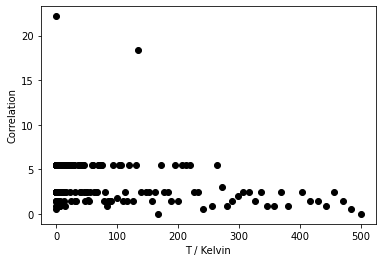

In [15]:
plt.close('all')
plt.figure()
plt.plot(T_plot_1,CL_plot_1,'ok')
#plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('Correlation')
#plt.xlim([1,0])
plt.show()

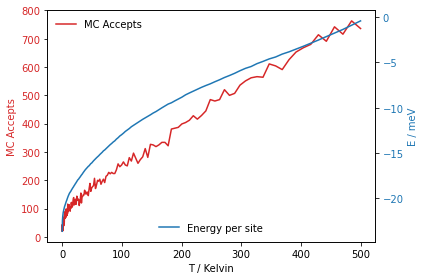

In [16]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('T / Kelvin')
ax1.set_ylabel('MC Accepts', color=color)
ax1.plot(T_plot_1,MCA_plot_1, color=color, label="MC Accepts")
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc="best",frameon=False)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('E / meV', color=color)  # we already handled the x-label with ax1
ax2.plot(T_plot_1,E_plot_1, color=color, label="Energy per site") 
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc="lower center",frameon=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

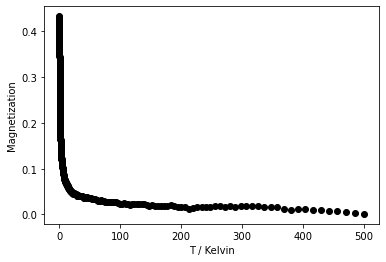

In [17]:
plt.close('all')
plt.figure()
plt.plot(T_plot_1,Mag_plot_1,'ok')
#plt.gca().invert_xaxis()
plt.xlabel('T / Kelvin')
plt.ylabel('Magnetization')
#plt.xlim([1,0])
plt.show()